In [1]:
import numpy as np 
import pandas as pd 
#import pydicom
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
from efficientnet_pytorch import EfficientNet

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
train_df = pd.read_csv("ENET_train_df.csv")
val_df = pd.read_csv("ENET_val_df.csv")
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

print("Training on {} images, validating on {} images.".format(train_df.shape[0], val_df.shape[0]))

Training on 27219 images, validating on 3025 images.


In [4]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, Net):
        super(MyENet, self).__init__()
        self.Net = Net
        self.output = nn.Sequential(
            nn.Linear(1000, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.Net(x)
        return out 
        
    def forward(self, x):
        out = self.Net(x)
        out = self.output(out)
        return out

model = MyENet(ENet).to(device)
# Load best model 
model.load_state_dict(torch.load('../Models/ENETmodel_all.ckpt'))

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

In [5]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(1.0, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_valid(img)
        
        # 3. get meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]


In [6]:
# Use the data loader.
'''
batch_size = 12
path = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"

train_dataset = ValidDataset(train_df, path)                                               
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(tqdm(train_loader)):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)
    
    # append the dataset
    try:
        X = np.concatenate((X, batch_features), 0)
        y = np.append(y, labels.numpy())
    except:
        X = batch_features 
        y = labels.numpy() 
'''

'\nbatch_size = 12\npath = "../../data-512/512x512-dataset-melanoma/512x512-dataset-melanoma/"\n\ntrain_dataset = ValidDataset(train_df, path)                                               \ntrain_loader = torch.utils.data.DataLoader(dataset=train_dataset, \n                                           batch_size=batch_size)   \n\nmodel = model.eval()\nfor i, (images, meta_data, labels) in enumerate(tqdm(train_loader)):\n    images = images.to(device)\n\n    # Forward pass\n    embed = model.embedding(images)\n    nn_pred = model.output(embed).detach().cpu().numpy()\n    embedding = embed.detach().cpu().numpy()\n\n    # determine NN features for the set of images \n    batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)\n    \n    # append the dataset\n    try:\n        X = np.concatenate((X, batch_features), 0)\n        y = np.append(y, labels.numpy())\n    except:\n        X = batch_features \n        y = labels.numpy() \n'

In [7]:
# Save X and y in pandas dataframe 
#XGB_data = pd.DataFrame(data=X)
#XGB_data['targets'] = y 
#XGB_data.to_csv("XGB_ENET_train_all.csv", index=False)
XGB_data = pd.read_csv("XGB_ENET_train.csv")

X = np.array(XGB_data.values[:, :-1], np.float32) 
y = np.array(XGB_data['targets'].values, np.float32)

# maybe normalize X? 
Xstd = (X - np.nanmean(X, 0)) / np.nanstd(X, 0) 

In [8]:
# weight positive examples more heavily 
def make_weights(targets):
    nclasses = len(np.unique(targets))
    count = [0] * nclasses                                                      
    for label in targets:                                                         
        count[np.int(label)] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(targets)                                              
    for idx, label in enumerate(targets):                                          
        weight[idx] = weight_per_class[np.int(label)]  
        
    return np.array(weight)

# define function to fit and return xgboost model 
def fit_xgboost(X_train, y_train, X_val, y_val):
    '''
    # weight positive examples more heavily 
    w = make_weights(y_train)

    dtrain = xgb.DMatrix(X_train, label=y_train) #, weight=w)
    dval = xgb.DMatrix(X_val, label=y_val) 

    # booster params 
    param = {'n_estimators':5000, 
            'max_depth':16,
            'learning_rate':0.02,
            'subsample':0.8,
            'eval_metric':'auc',
            'objective': 'binary:logistic',
            'nthread': 8}

    # specify validation set 
    evallist = [(dval, 'eval')]

    # Training 
    num_round = 5000
    bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=50)
    ''' 
    clf = xgb.XGBClassifier( 
        n_estimators=5000,
        max_depth=16, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4,
        eval_metric='auc',
    )
    
    clf.fit(X_train, y_train, 
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50)
    
    return clf

In [9]:
'''
batch_size = 4
valid_dataset = ValidDataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

model = model.eval()
for i, (images, meta_data, labels) in enumerate(tqdm(valid_loader)):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)
    
    # append the dataset
    try:
        Xval = np.concatenate((Xval, batch_features), 0)
        yval = np.append(yval, labels.numpy())
    except:
        Xval = batch_features 
        yval = labels.numpy() 
        
XGB_data = pd.DataFrame(data=Xval)
XGB_data['targets'] = yval 
XGB_data.to_csv("XGB_ENET_val_all.csv", index=False)
'''
XGB_data = pd.read_csv("XGB_ENET_val.csv")
Xval = np.array(XGB_data.values[:, :-1], np.float32) 
yval = np.array(XGB_data['targets'].values, np.float32)

Xval = (Xval - np.nanmean(X, 0)) / np.nanstd(X, 0)

In [10]:
# Seems like stratified k-fold training and prediction is a very prominent strategy among high scoring models 
n_splits = 5
skf = StratifiedKFold(n_splits, shuffle=True)
skf.get_n_splits(Xstd, y)

print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [11]:
# define "out of fold" set of predictions, represents validation performance  
oof = np.zeros(len(Xstd))
ypred = np.zeros(len(Xval))

for i, (train_index, test_index) in enumerate(skf.split(Xstd, y)):
    
    # get data partitions for Xtrain and Xval
    X_train, X_test = Xstd[train_index], Xstd[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train xgboost 
    bst = fit_xgboost(X_train, y_train, X_test, y_test)
    
    # save out of fold predictions 
    probas = bst.predict_proba(X_test)
    oof_pred = np.array([p[1] for p in probas])
    oof[test_index] += oof_pred
    
    # save current model predictions on the true validation set 
    probas = bst.predict_proba(Xval)
    val_pred = np.array([p[1] for p in probas])
    ypred += val_pred / skf.n_splits

[0]	validation_0-auc:0.893432
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.912357
[2]	validation_0-auc:0.917782
[3]	validation_0-auc:0.919867
[4]	validation_0-auc:0.920396
[5]	validation_0-auc:0.921023
[6]	validation_0-auc:0.919
[7]	validation_0-auc:0.919164
[8]	validation_0-auc:0.91872
[9]	validation_0-auc:0.91943
[10]	validation_0-auc:0.919026
[11]	validation_0-auc:0.919504
[12]	validation_0-auc:0.920406
[13]	validation_0-auc:0.920058
[14]	validation_0-auc:0.92063
[15]	validation_0-auc:0.921224
[16]	validation_0-auc:0.921038
[17]	validation_0-auc:0.920617
[18]	validation_0-auc:0.920852
[19]	validation_0-auc:0.921042
[20]	validation_0-auc:0.921156
[21]	validation_0-auc:0.921079
[22]	validation_0-auc:0.921242
[23]	validation_0-auc:0.921277
[24]	validation_0-auc:0.921367
[25]	validation_0-auc:0.922296
[26]	validation_0-auc:0.922835
[27]	validation_0-auc:0.922853
[28]	validation_0-auc:0.923281
[29]	validation_0-auc:0.923377
[30]	validation_0-auc:

[259]	validation_0-auc:0.933439
[260]	validation_0-auc:0.933402
[261]	validation_0-auc:0.933411
[262]	validation_0-auc:0.933434
[263]	validation_0-auc:0.933484
[264]	validation_0-auc:0.933479
[265]	validation_0-auc:0.933458
[266]	validation_0-auc:0.933473
[267]	validation_0-auc:0.933539
[268]	validation_0-auc:0.933714
[269]	validation_0-auc:0.933753
[270]	validation_0-auc:0.933761
[271]	validation_0-auc:0.933739
[272]	validation_0-auc:0.933731
[273]	validation_0-auc:0.933783
[274]	validation_0-auc:0.933801
[275]	validation_0-auc:0.933824
[276]	validation_0-auc:0.93392
[277]	validation_0-auc:0.933947
[278]	validation_0-auc:0.933964
[279]	validation_0-auc:0.934006
[280]	validation_0-auc:0.934047
[281]	validation_0-auc:0.934127
[282]	validation_0-auc:0.934174
[283]	validation_0-auc:0.934145
[284]	validation_0-auc:0.934198
[285]	validation_0-auc:0.934207
[286]	validation_0-auc:0.934259
[287]	validation_0-auc:0.934222
[288]	validation_0-auc:0.934247
[289]	validation_0-auc:0.934308
[290]	val

[516]	validation_0-auc:0.937375
[517]	validation_0-auc:0.937373
[518]	validation_0-auc:0.937363
[519]	validation_0-auc:0.937386
[520]	validation_0-auc:0.93736
[521]	validation_0-auc:0.937352
[522]	validation_0-auc:0.937346
[523]	validation_0-auc:0.937325
[524]	validation_0-auc:0.937337
[525]	validation_0-auc:0.937309
[526]	validation_0-auc:0.937373
[527]	validation_0-auc:0.937353
[528]	validation_0-auc:0.937358
[529]	validation_0-auc:0.937364
[530]	validation_0-auc:0.937343
[531]	validation_0-auc:0.937335
[532]	validation_0-auc:0.937337
[533]	validation_0-auc:0.93734
[534]	validation_0-auc:0.937321
[535]	validation_0-auc:0.93734
[536]	validation_0-auc:0.937303
[537]	validation_0-auc:0.937347
[538]	validation_0-auc:0.93733
[539]	validation_0-auc:0.937329
[540]	validation_0-auc:0.937385
[541]	validation_0-auc:0.937389
[542]	validation_0-auc:0.937425
[543]	validation_0-auc:0.93743
[544]	validation_0-auc:0.937418
[545]	validation_0-auc:0.937445
[546]	validation_0-auc:0.937437
[547]	validat

[154]	validation_0-auc:0.924534
[155]	validation_0-auc:0.924537
[156]	validation_0-auc:0.924515
[157]	validation_0-auc:0.924727
[158]	validation_0-auc:0.924894
[159]	validation_0-auc:0.925151
[160]	validation_0-auc:0.925287
[161]	validation_0-auc:0.925332
[162]	validation_0-auc:0.925323
[163]	validation_0-auc:0.925401
[164]	validation_0-auc:0.925437
[165]	validation_0-auc:0.925485
[166]	validation_0-auc:0.925462
[167]	validation_0-auc:0.925609
[168]	validation_0-auc:0.925578
[169]	validation_0-auc:0.925685
[170]	validation_0-auc:0.925719
[171]	validation_0-auc:0.925705
[172]	validation_0-auc:0.925841
[173]	validation_0-auc:0.925928
[174]	validation_0-auc:0.925988
[175]	validation_0-auc:0.925986
[176]	validation_0-auc:0.926034
[177]	validation_0-auc:0.925986
[178]	validation_0-auc:0.926079
[179]	validation_0-auc:0.92624
[180]	validation_0-auc:0.926233
[181]	validation_0-auc:0.926216
[182]	validation_0-auc:0.926233
[183]	validation_0-auc:0.926336
[184]	validation_0-auc:0.926393
[185]	val

[411]	validation_0-auc:0.931125
[412]	validation_0-auc:0.931134
[413]	validation_0-auc:0.931148
[414]	validation_0-auc:0.931148
[415]	validation_0-auc:0.931132
[416]	validation_0-auc:0.931135
[417]	validation_0-auc:0.931134
[418]	validation_0-auc:0.931161
[419]	validation_0-auc:0.931154
[420]	validation_0-auc:0.931202
[421]	validation_0-auc:0.931186
[422]	validation_0-auc:0.93121
[423]	validation_0-auc:0.931221
[424]	validation_0-auc:0.931229
[425]	validation_0-auc:0.931236
[426]	validation_0-auc:0.931228
[427]	validation_0-auc:0.931197
[428]	validation_0-auc:0.931193
[429]	validation_0-auc:0.931189
[430]	validation_0-auc:0.93123
[431]	validation_0-auc:0.931264
[432]	validation_0-auc:0.9313
[433]	validation_0-auc:0.931314
[434]	validation_0-auc:0.931324
[435]	validation_0-auc:0.931341
[436]	validation_0-auc:0.931304
[437]	validation_0-auc:0.931297
[438]	validation_0-auc:0.931276
[439]	validation_0-auc:0.931269
[440]	validation_0-auc:0.931257
[441]	validation_0-auc:0.931261
[442]	valida

[669]	validation_0-auc:0.932362
[670]	validation_0-auc:0.932347
[671]	validation_0-auc:0.93233
[672]	validation_0-auc:0.932344
[673]	validation_0-auc:0.932343
[674]	validation_0-auc:0.932335
[675]	validation_0-auc:0.932329
[676]	validation_0-auc:0.932312
[677]	validation_0-auc:0.932318
[678]	validation_0-auc:0.932317
[679]	validation_0-auc:0.932334
[680]	validation_0-auc:0.932348
[681]	validation_0-auc:0.932326
[682]	validation_0-auc:0.932351
[683]	validation_0-auc:0.932355
[684]	validation_0-auc:0.932324
[685]	validation_0-auc:0.932333
[686]	validation_0-auc:0.932334
[687]	validation_0-auc:0.932337
[688]	validation_0-auc:0.932364
[689]	validation_0-auc:0.932374
[690]	validation_0-auc:0.932398
[691]	validation_0-auc:0.932413
[692]	validation_0-auc:0.932406
[693]	validation_0-auc:0.932409
[694]	validation_0-auc:0.932434
[695]	validation_0-auc:0.932412
[696]	validation_0-auc:0.932429
[697]	validation_0-auc:0.932431
[698]	validation_0-auc:0.932467
[699]	validation_0-auc:0.932468
[700]	val

[927]	validation_0-auc:0.933145
[928]	validation_0-auc:0.933136
[929]	validation_0-auc:0.933142
[930]	validation_0-auc:0.933142
[931]	validation_0-auc:0.933174
[932]	validation_0-auc:0.933168
[933]	validation_0-auc:0.933151
[934]	validation_0-auc:0.933168
[935]	validation_0-auc:0.933172
[936]	validation_0-auc:0.933173
[937]	validation_0-auc:0.933174
[938]	validation_0-auc:0.933155
[939]	validation_0-auc:0.933175
[940]	validation_0-auc:0.933212
[941]	validation_0-auc:0.933214
[942]	validation_0-auc:0.93322
[943]	validation_0-auc:0.933232
[944]	validation_0-auc:0.933247
[945]	validation_0-auc:0.933248
[946]	validation_0-auc:0.93324
[947]	validation_0-auc:0.933233
[948]	validation_0-auc:0.93324
[949]	validation_0-auc:0.93322
[950]	validation_0-auc:0.933208
[951]	validation_0-auc:0.933246
[952]	validation_0-auc:0.933226
[953]	validation_0-auc:0.933243
[954]	validation_0-auc:0.933227
[955]	validation_0-auc:0.933233
[956]	validation_0-auc:0.933243
[957]	validation_0-auc:0.933249
[958]	valida

[1179]	validation_0-auc:0.933764
[1180]	validation_0-auc:0.933773
[1181]	validation_0-auc:0.93377
[1182]	validation_0-auc:0.933767
[1183]	validation_0-auc:0.933775
[1184]	validation_0-auc:0.933778
[1185]	validation_0-auc:0.933775
[1186]	validation_0-auc:0.933757
[1187]	validation_0-auc:0.933759
[1188]	validation_0-auc:0.933767
[1189]	validation_0-auc:0.933757
[1190]	validation_0-auc:0.933763
[1191]	validation_0-auc:0.933784
[1192]	validation_0-auc:0.933791
[1193]	validation_0-auc:0.933803
[1194]	validation_0-auc:0.933812
[1195]	validation_0-auc:0.933828
[1196]	validation_0-auc:0.933811
[1197]	validation_0-auc:0.933836
[1198]	validation_0-auc:0.933838
[1199]	validation_0-auc:0.933836
[1200]	validation_0-auc:0.933834
[1201]	validation_0-auc:0.933838
[1202]	validation_0-auc:0.933821
[1203]	validation_0-auc:0.933807
[1204]	validation_0-auc:0.933816
[1205]	validation_0-auc:0.933819
[1206]	validation_0-auc:0.933815
[1207]	validation_0-auc:0.933797
[1208]	validation_0-auc:0.933799
[1209]	vali

[1428]	validation_0-auc:0.934044
[1429]	validation_0-auc:0.934048
[1430]	validation_0-auc:0.934057
[1431]	validation_0-auc:0.934063
[1432]	validation_0-auc:0.93407
[1433]	validation_0-auc:0.934055
[1434]	validation_0-auc:0.934054
[1435]	validation_0-auc:0.934053
[1436]	validation_0-auc:0.934049
[1437]	validation_0-auc:0.934047
[1438]	validation_0-auc:0.934071
[1439]	validation_0-auc:0.934079
[1440]	validation_0-auc:0.934077
[1441]	validation_0-auc:0.934072
[1442]	validation_0-auc:0.934076
[1443]	validation_0-auc:0.934084
[1444]	validation_0-auc:0.934071
[1445]	validation_0-auc:0.93407
[1446]	validation_0-auc:0.934048
[1447]	validation_0-auc:0.93404
[1448]	validation_0-auc:0.934062
[1449]	validation_0-auc:0.93407
[1450]	validation_0-auc:0.93406
[1451]	validation_0-auc:0.934085
[1452]	validation_0-auc:0.934095
[1453]	validation_0-auc:0.9341
[1454]	validation_0-auc:0.934092
[1455]	validation_0-auc:0.934113
[1456]	validation_0-auc:0.93411
[1457]	validation_0-auc:0.934096
[1458]	validation_

[55]	validation_0-auc:0.932435
[56]	validation_0-auc:0.932372
[57]	validation_0-auc:0.932081
[58]	validation_0-auc:0.93202
[59]	validation_0-auc:0.931939
[60]	validation_0-auc:0.931794
[61]	validation_0-auc:0.931492
[62]	validation_0-auc:0.931643
[63]	validation_0-auc:0.931859
[64]	validation_0-auc:0.931748
[65]	validation_0-auc:0.931637
[66]	validation_0-auc:0.93157
[67]	validation_0-auc:0.931456
[68]	validation_0-auc:0.931531
[69]	validation_0-auc:0.931248
[70]	validation_0-auc:0.931195
[71]	validation_0-auc:0.93135
[72]	validation_0-auc:0.931204
[73]	validation_0-auc:0.931081
[74]	validation_0-auc:0.931259
[75]	validation_0-auc:0.931208
[76]	validation_0-auc:0.931352
[77]	validation_0-auc:0.931279
[78]	validation_0-auc:0.931507
[79]	validation_0-auc:0.931455
[80]	validation_0-auc:0.931739
[81]	validation_0-auc:0.931702
[82]	validation_0-auc:0.931995
[83]	validation_0-auc:0.93218
[84]	validation_0-auc:0.932199
[85]	validation_0-auc:0.932165
[86]	validation_0-auc:0.932061
[87]	validat

[314]	validation_0-auc:0.935379
[315]	validation_0-auc:0.935384
[316]	validation_0-auc:0.935416
[317]	validation_0-auc:0.93546
[318]	validation_0-auc:0.935397
[319]	validation_0-auc:0.935406
[320]	validation_0-auc:0.935441
[321]	validation_0-auc:0.935464
[322]	validation_0-auc:0.935444
[323]	validation_0-auc:0.935522
[324]	validation_0-auc:0.935559
[325]	validation_0-auc:0.935567
[326]	validation_0-auc:0.935595
[327]	validation_0-auc:0.93559
[328]	validation_0-auc:0.935596
[329]	validation_0-auc:0.93553
[330]	validation_0-auc:0.935548
[331]	validation_0-auc:0.935539
[332]	validation_0-auc:0.935524
[333]	validation_0-auc:0.935536
[334]	validation_0-auc:0.935545
[335]	validation_0-auc:0.935572
[336]	validation_0-auc:0.935591
[337]	validation_0-auc:0.935607
[338]	validation_0-auc:0.935625
[339]	validation_0-auc:0.935696
[340]	validation_0-auc:0.935702
[341]	validation_0-auc:0.935698
[342]	validation_0-auc:0.935694
[343]	validation_0-auc:0.93572
[344]	validation_0-auc:0.935741
[345]	valida

[35]	validation_0-auc:0.914253
[36]	validation_0-auc:0.914627
[37]	validation_0-auc:0.914624
[38]	validation_0-auc:0.915127
[39]	validation_0-auc:0.915185
[40]	validation_0-auc:0.91515
[41]	validation_0-auc:0.91554
[42]	validation_0-auc:0.915953
[43]	validation_0-auc:0.915659
[44]	validation_0-auc:0.91589
[45]	validation_0-auc:0.916342
[46]	validation_0-auc:0.916552
[47]	validation_0-auc:0.916713
[48]	validation_0-auc:0.91669
[49]	validation_0-auc:0.916873
[50]	validation_0-auc:0.916967
[51]	validation_0-auc:0.917125
[52]	validation_0-auc:0.917332
[53]	validation_0-auc:0.917521
[54]	validation_0-auc:0.917483
[55]	validation_0-auc:0.917546
[56]	validation_0-auc:0.917756
[57]	validation_0-auc:0.917694
[58]	validation_0-auc:0.917614
[59]	validation_0-auc:0.917669
[60]	validation_0-auc:0.917762
[61]	validation_0-auc:0.917666
[62]	validation_0-auc:0.917622
[63]	validation_0-auc:0.917519
[64]	validation_0-auc:0.917673
[65]	validation_0-auc:0.917628
[66]	validation_0-auc:0.917854
[67]	validat

[295]	validation_0-auc:0.926221
[296]	validation_0-auc:0.926304
[297]	validation_0-auc:0.926361
[298]	validation_0-auc:0.926347
[299]	validation_0-auc:0.926401
[300]	validation_0-auc:0.926417
[301]	validation_0-auc:0.926522
[302]	validation_0-auc:0.926491
[303]	validation_0-auc:0.926499
[304]	validation_0-auc:0.926511
[305]	validation_0-auc:0.926522
[306]	validation_0-auc:0.92654
[307]	validation_0-auc:0.926542
[308]	validation_0-auc:0.926603
[309]	validation_0-auc:0.926633
[310]	validation_0-auc:0.926676
[311]	validation_0-auc:0.926741
[312]	validation_0-auc:0.926783
[313]	validation_0-auc:0.926785
[314]	validation_0-auc:0.926843
[315]	validation_0-auc:0.926834
[316]	validation_0-auc:0.926831
[317]	validation_0-auc:0.926824
[318]	validation_0-auc:0.926839
[319]	validation_0-auc:0.926869
[320]	validation_0-auc:0.926876
[321]	validation_0-auc:0.926883
[322]	validation_0-auc:0.926884
[323]	validation_0-auc:0.926886
[324]	validation_0-auc:0.926926
[325]	validation_0-auc:0.926945
[326]	val

[552]	validation_0-auc:0.927921
[553]	validation_0-auc:0.927923
[554]	validation_0-auc:0.927905
[555]	validation_0-auc:0.927932
[556]	validation_0-auc:0.927929
[557]	validation_0-auc:0.927933
[558]	validation_0-auc:0.927906
[559]	validation_0-auc:0.92791
[560]	validation_0-auc:0.927902
[561]	validation_0-auc:0.927896
[562]	validation_0-auc:0.927888
[563]	validation_0-auc:0.927902
[564]	validation_0-auc:0.927919
[565]	validation_0-auc:0.927898
[566]	validation_0-auc:0.927895
[567]	validation_0-auc:0.927898
[568]	validation_0-auc:0.927902
[569]	validation_0-auc:0.927866
[570]	validation_0-auc:0.92787
[571]	validation_0-auc:0.927888
[572]	validation_0-auc:0.927872
[573]	validation_0-auc:0.927883
[574]	validation_0-auc:0.927861
[575]	validation_0-auc:0.927851
[576]	validation_0-auc:0.927858
[577]	validation_0-auc:0.92787
[578]	validation_0-auc:0.927865
[579]	validation_0-auc:0.927848
[580]	validation_0-auc:0.927875
[581]	validation_0-auc:0.92783
[582]	validation_0-auc:0.927829
[583]	valida

[224]	validation_0-auc:0.928034
[225]	validation_0-auc:0.927989
[226]	validation_0-auc:0.927946
[227]	validation_0-auc:0.928157
[228]	validation_0-auc:0.928211
[229]	validation_0-auc:0.928179
[230]	validation_0-auc:0.928225
[231]	validation_0-auc:0.928242
[232]	validation_0-auc:0.928247
[233]	validation_0-auc:0.92827
[234]	validation_0-auc:0.928258
[235]	validation_0-auc:0.928314
[236]	validation_0-auc:0.92835
[237]	validation_0-auc:0.92836
[238]	validation_0-auc:0.928322
[239]	validation_0-auc:0.928429
[240]	validation_0-auc:0.928397
[241]	validation_0-auc:0.92851
[242]	validation_0-auc:0.928544
[243]	validation_0-auc:0.928543
[244]	validation_0-auc:0.9285
[245]	validation_0-auc:0.928524
[246]	validation_0-auc:0.928523
[247]	validation_0-auc:0.928638
[248]	validation_0-auc:0.928637
[249]	validation_0-auc:0.92865
[250]	validation_0-auc:0.928607
[251]	validation_0-auc:0.928731
[252]	validation_0-auc:0.928774
[253]	validation_0-auc:0.928782
[254]	validation_0-auc:0.928777
[255]	validatio

[482]	validation_0-auc:0.932182
[483]	validation_0-auc:0.932164
[484]	validation_0-auc:0.932166
[485]	validation_0-auc:0.93221
[486]	validation_0-auc:0.932189
[487]	validation_0-auc:0.932191
[488]	validation_0-auc:0.932226
[489]	validation_0-auc:0.932221
[490]	validation_0-auc:0.932259
[491]	validation_0-auc:0.932233
[492]	validation_0-auc:0.932238
[493]	validation_0-auc:0.932232
[494]	validation_0-auc:0.932268
[495]	validation_0-auc:0.932245
[496]	validation_0-auc:0.932237
[497]	validation_0-auc:0.932249
[498]	validation_0-auc:0.932275
[499]	validation_0-auc:0.932248
[500]	validation_0-auc:0.932248
[501]	validation_0-auc:0.932255
[502]	validation_0-auc:0.932313
[503]	validation_0-auc:0.932311
[504]	validation_0-auc:0.932354
[505]	validation_0-auc:0.932375
[506]	validation_0-auc:0.932372
[507]	validation_0-auc:0.93239
[508]	validation_0-auc:0.932416
[509]	validation_0-auc:0.932421
[510]	validation_0-auc:0.932395
[511]	validation_0-auc:0.932391
[512]	validation_0-auc:0.932404
[513]	vali

[740]	validation_0-auc:0.933028
[741]	validation_0-auc:0.93303
[742]	validation_0-auc:0.933033
[743]	validation_0-auc:0.933059
[744]	validation_0-auc:0.933074
[745]	validation_0-auc:0.933081
[746]	validation_0-auc:0.933056
[747]	validation_0-auc:0.933055
[748]	validation_0-auc:0.933079
[749]	validation_0-auc:0.933078
[750]	validation_0-auc:0.9331
[751]	validation_0-auc:0.933112
[752]	validation_0-auc:0.933123
[753]	validation_0-auc:0.93312
[754]	validation_0-auc:0.933116
[755]	validation_0-auc:0.933122
[756]	validation_0-auc:0.933134
[757]	validation_0-auc:0.933156
[758]	validation_0-auc:0.933171
[759]	validation_0-auc:0.933183
[760]	validation_0-auc:0.933173
[761]	validation_0-auc:0.933156
[762]	validation_0-auc:0.933171
[763]	validation_0-auc:0.933155
[764]	validation_0-auc:0.933146
[765]	validation_0-auc:0.93315
[766]	validation_0-auc:0.933168
[767]	validation_0-auc:0.933183
[768]	validation_0-auc:0.933208
[769]	validation_0-auc:0.933224
[770]	validation_0-auc:0.933248
[771]	validat

In [12]:
probas = bst.predict_proba(X_test)

In [13]:
pred = [p[1] for p in probas]

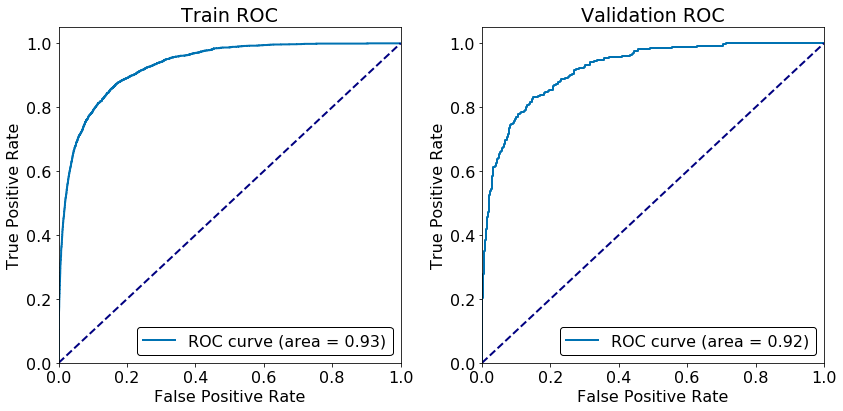

In [14]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 

plt.figure(figsize=(12, 6))

plt.subplot(121)

fpr, tpr, _ = roc_curve(y, oof)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

plt.subplot(122)

fpr, tpr, _ = roc_curve(yval, ypred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [15]:
val_acc = accuracy_score(yval, np.round(ypred))
print("validation accuracy: {:.3f}".format(val_acc))

validation accuracy: 0.935


In [16]:
Xval = np.array(XGB_data.values[:, :-1], np.float32) 
yval = np.array(XGB_data['targets'].values, np.float32)

tn, fp, fn, tp = confusion_matrix(yval, np.round(Xval[:, -1])).ravel()

accuracy = (tp + tn) / len(yval)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

print("CNN Stats:")

print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(yval, np.round(Xval[:, -1])))

tn, fp, fn, tp = confusion_matrix(yval, np.round(ypred)).ravel()

accuracy = (tp + tn) / len(yval)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

print("\nXGBoost Stats:")

print("Model accuracy: {:.2f}".format(accuracy))
print("Model precision: {:.2f}".format(precision))
print("Model recall: {:.2f}".format(recall))

print("\nConfusion Matrix: ")
print(confusion_matrix(yval, np.round(ypred)))

tn, fp, fn, tp = confusion_matrix(yval, np.round(Xval[:, -1]*(2/4) + ypred*(2/4))).ravel()

accuracy = (tp + tn) / len(yval)
# precision is the fraction of correctly identified positive samples
# precision asks:"Of all the samples identified as positives, how many were correct?"
precision = tp / (tp + fp)
# recall is the ability of the model to identify positive samples 
# recall asks:"Of all the positive samples in the dataset, how many were identified by the model?"
recall = tp / (tp + fn)

CNN Stats:
Model accuracy: 0.84
Model precision: 0.34
Model recall: 0.81

Confusion Matrix: 
[[2310  441]
 [  51  223]]

XGBoost Stats:
Model accuracy: 0.94
Model precision: 0.75
Model recall: 0.43

Confusion Matrix: 
[[2711   40]
 [ 156  118]]


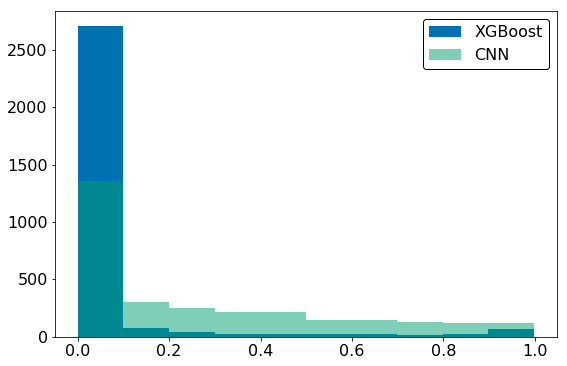

In [17]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

plt.hist(ypred, label='XGBoost')
plt.hist(Xval[:, -1], label='CNN', alpha=.5)
plt.legend()
plt.show()

In [18]:
import seaborn as sns

bst_feature_dict = bst.get_score(importance_type='gain')
feature_names = list(bst_feature_dict.keys())
feature_importance = [bst_feature_dict[key] for key in feature_names]
feature_imp = pd.DataFrame()
feature_imp['Feature'] = feature_names 
feature_imp['Value'] = feature_importance

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

AttributeError: 'XGBClassifier' object has no attribute 'get_score'

In [ ]:
# Next try "test time augmentation" 
'''
# 
transform_TTA = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


class TTADataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_id'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform).
        img = Image.fromarray(img)
        #img = img.resize((256, 256))
        img_processed = transform_TTA(img)
        
        # 3. get meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

N_TTA = 5
batch_size = 1
valid_dataset = TTADataset(val_df, path)                                               
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, 
                                           batch_size=batch_size)   

ypred_TTA = np.zeros((len(ypred), N_TTA))

model = model.eval()
for j in range(N_TTA):
    for i, (images, meta_data, labels) in enumerate(tqdm(valid_loader)):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model.output(embed).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data.numpy(), nn_pred), axis=1)

        ypred_TTA[i, j] = bst.predict(xgb.DMatrix(batch_features))
ypred_TTA_mean = np.mean(ypred_TTA, 1)
'''